In [13]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import os
from pathlib import Path
import json
%matplotlib widget


plt.style.use('default')


In [14]:
max_nodes = 30


In [15]:
# os.environ['SUDO_ASKPASS'] = '/usr/bin/ksshaskpass'


# for i in range(1, 11):
#     os.system('sudo --askpass mn --clean')
#     os.system(
#         f'sudo --askpass python ../tests/MN_CDN_test.py solo {i} 10 100 1000 outputs/20hop_solo_1000/{i}.json')

# for i in range(1, 11):
#     os.system('sudo --askpass mn --clean')
#     os.system(
#         f'sudo --askpass python ../tests/MN_CDN_test.py peer {i} 10 100 1000 outputs/20hop_peer_1000/{i}.json')


In [16]:
solo_raw_stats = {}
# solo_raw_stats[10]={i:json.loads(Path(f'../outputs/solo10/{i}.json').read_text()) for i in range(1,11)}
# solo_raw_stats[100]={i:json.loads(Path(f'../outputs/solo100/{i}.json').read_text()) for i in range(1,11)}
solo_raw_stats[1000] = {i: json.loads(
    Path(f'../outputs/20hop_solo_1000/{i}.json').read_text()) for i in range(1, max_nodes+1)}


In [17]:
solo_stats = {}

for size, data in solo_raw_stats.items():
    solo_stats[size] = {}
    solo_stats[size]['rx'] = []
    solo_stats[size]['server'] = []

    for i, x in data.items():
        server_requests = x['server']['count']

        # tx_bytes_total=0
        rx_bytes_total = 0

        for intf in x['stats']['s1']:
            if '-eth' not in intf['ifname']:
                continue
            if 's19' in intf['ifname']:
                continue

            # tx_bytes_total+=intf['stats64']['tx']['bytes']
            rx_bytes_total += intf['stats64']['rx']['bytes']

        # solo_stats[size][i]={}
        # solo_stats[i]['tx']=tx_bytes_total
        solo_stats[size]['rx'].append(rx_bytes_total)
        solo_stats[size]['server'].append(server_requests)


In [18]:
peer_raw_stats = {}
# peer_raw_stats[10]={i:json.loads(Path(f'../outputs/peer10/{i}.json').read_text()) for i in range(1,11)}
# peer_raw_stats[100]={i:json.loads(Path(f'../outputs/peer100/{i}.json').read_text()) for i in range(1,11)}
peer_raw_stats[1000] = {i: json.loads(
    Path(f'../outputs/20hop_peer_1000/{i}.json').read_text()) for i in range(1, max_nodes+1)}


In [19]:
peer_stats = {}

for size, data in peer_raw_stats.items():
    peer_stats[size] = {}
    peer_stats[size]['rx'] = []
    peer_stats[size]['server'] = []

    for i, x in data.items():
        server_requests = x['clients']['h1']['count']

        # tx_bytes_total=0
        rx_bytes_total = 0

        for intf in x['stats']['s1']:
            if '-eth' not in intf['ifname']:
                continue
            if 's19' in intf['ifname']:
                continue

            # tx_bytes_total+=intf['stats64']['tx']['bytes']
            rx_bytes_total += intf['stats64']['rx']['bytes']

        # peer_stats[size][i]={}
        # solo_stats[i]['tx']=tx_bytes_total
        peer_stats[size]['rx'].append(rx_bytes_total)
        peer_stats[size]['server'].append(server_requests)


In [20]:
def lin_fit(x, m):
    return m*x


def lin_fit_with_c(x, m, c):
    return m*x+c


def exp_fit(x, a, b, c):
    return a * np.exp(b * x) + c


[398403.22220877]
[ 1.41187898e+06  6.18513317e-02 -8.41667438e+05]


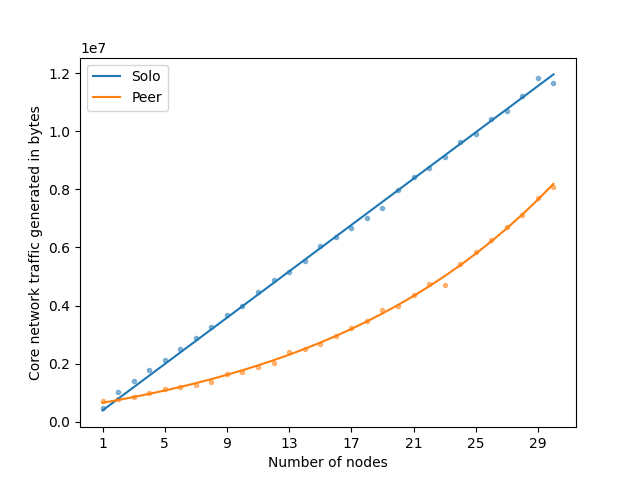

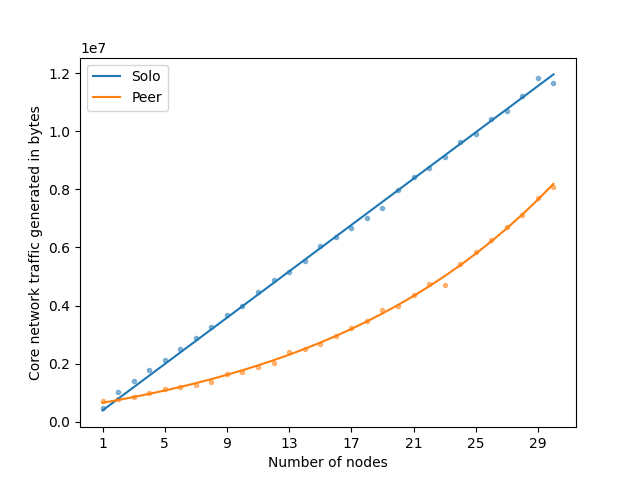

In [21]:
solo_rx = solo_stats[1000]['rx']
peer_rx = peer_stats[1000]['rx']

fig = plt.figure('rx')
plt.clf()

plt.scatter(range(1, max_nodes+1), solo_rx, marker='.', alpha=0.5)
plt.scatter(range(1, max_nodes+1), peer_rx, marker='.', alpha=0.5)

solo_popt, solo_pcov = curve_fit(lin_fit, range(1, max_nodes+1), solo_rx)
print(solo_popt)
peer_popt, peer_pcov = curve_fit(exp_fit, range(1, max_nodes+1), peer_rx)
print(peer_popt)

plt.plot(range(1, max_nodes+1),
         lin_fit(range(1, max_nodes+1), *solo_popt), label='Solo')
plt.plot(range(1, max_nodes+1),
         exp_fit(range(1, max_nodes+1), *peer_popt), label='Peer')

plt.xticks(range(1, max_nodes+1, 4))
plt.legend()
plt.xlabel('Number of nodes')
plt.ylabel('Core network traffic generated in bytes')

fig.canvas.header_visible = False
display(fig.canvas)

plt.savefig('traffic_core_20hop.pdf')



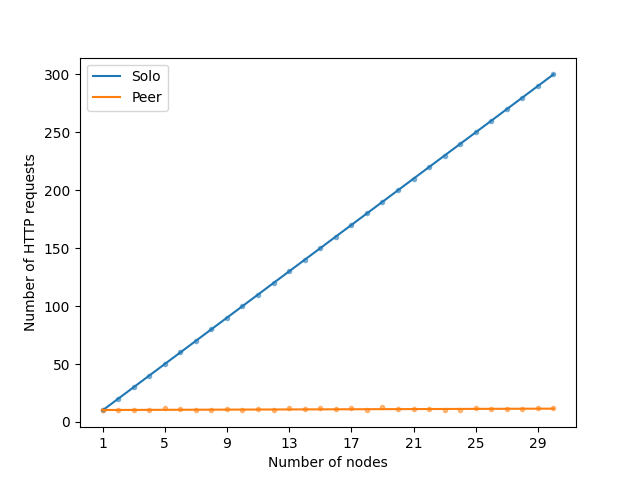

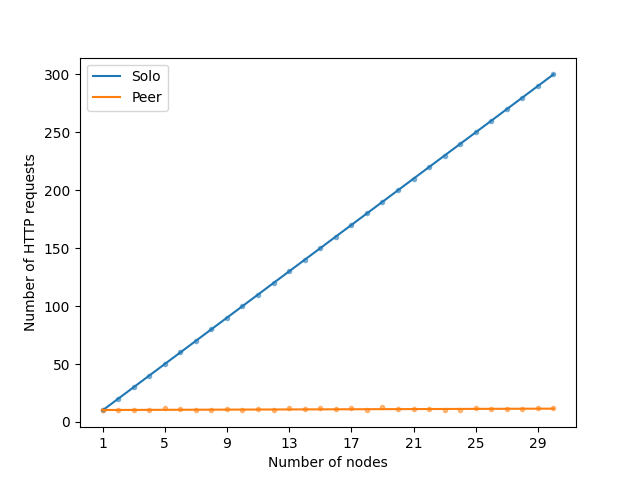

In [22]:
solo_server = solo_stats[1000]['server']
peer_server = peer_stats[1000]['server']

fig = plt.figure('server')
plt.clf()

plt.scatter(range(1, max_nodes+1), solo_server, marker='.', alpha=0.5)
plt.scatter(range(1, max_nodes+1), peer_server, marker='.', alpha=0.5)

solo_popt, solo_pcov = curve_fit(lin_fit, range(1, max_nodes+1), solo_server)
peer_popt, peer_pcov = curve_fit(
    lin_fit_with_c, range(1, max_nodes+1), peer_server)

plt.plot(range(1, max_nodes+1),
         lin_fit(range(1, max_nodes+1), *solo_popt), label='Solo')
plt.plot(range(1, max_nodes+1),
         lin_fit_with_c(range(1, max_nodes+1), *peer_popt), label='Peer')

plt.xticks(range(1, max_nodes+1, 4))
plt.legend()
plt.xlabel('Number of nodes')
plt.ylabel('Number of HTTP requests')

fig.canvas.header_visible = False
display(fig.canvas)

plt.savefig('server_load_20hop.pdf')
